### Allele Count

Quick experiment to see how Dask tasks are defined for counting unique elements of an array (across axes) in a loop.

In [30]:
import dask.array as da
import numpy as np
import xarray as xr
xr.set_options(display_style='text');

In [43]:
class Array:
    
    def __init__(self, x):
        self.x = x
        self.ndim = x.ndim
        self.shape = x.shape
        self.dtype = x.dtype
        
    def __getitem__(self, idx):
        if any(map(lambda s: s.stop, idx)):
            print('Fetching slice:', idx)
        return self.x[idx]

In [62]:
n_alleles = 4
gt = np.random.randint(0, n_alleles, size=5000).reshape(100, 25, 2)
gt = da.from_array(Array(gt), chunks=(25, 25, 2))
gt

dask.array<array, shape=(100, 25, 2), dtype=int64, chunksize=(25, 25, 2), chunktype=numpy.ndarray>

In [63]:
ds = xr.Dataset({'call/genotype': (('variant', 'sample', 'ploidy'), gt)})
ds

<xarray.Dataset>
Dimensions:        (ploidy: 2, sample: 25, variant: 100)
Dimensions without coordinates: ploidy, sample, variant
Data variables:
    call/genotype  (variant, sample, ploidy) int64 dask.array<chunksize=(25, 25, 2), meta=np.ndarray>

In [64]:
ac = xr.concat([
    (ds['call/genotype'] == i).sum(dim=('sample', 'ploidy'))
    for i in range(n_alleles)
], dim='alleles').T
ac

<xarray.DataArray 'call/genotype' (variant: 100, alleles: 4)>
dask.array<transpose, shape=(100, 4), dtype=int64, chunksize=(25, 1), chunktype=numpy.ndarray>
Dimensions without coordinates: variant, alleles

In [65]:
# Note that each slice of the underlying array is only fetched once
ac.compute(scheduler='single-threaded')[:5]

Fetching slice: (slice(0, 25, None), slice(0, 25, None), slice(0, 2, None))
Fetching slice: (slice(25, 50, None), slice(0, 25, None), slice(0, 2, None))
Fetching slice: (slice(50, 75, None), slice(0, 25, None), slice(0, 2, None))
Fetching slice: (slice(75, 100, None), slice(0, 25, None), slice(0, 2, None))


<xarray.DataArray 'call/genotype' (variant: 5, alleles: 4)>
array([[ 6, 17, 15, 12],
       [14,  8, 13, 15],
       [13,  8, 19, 10],
       [10, 11,  9, 20],
       [14, 13, 12, 11]])
Dimensions without coordinates: variant, alleles

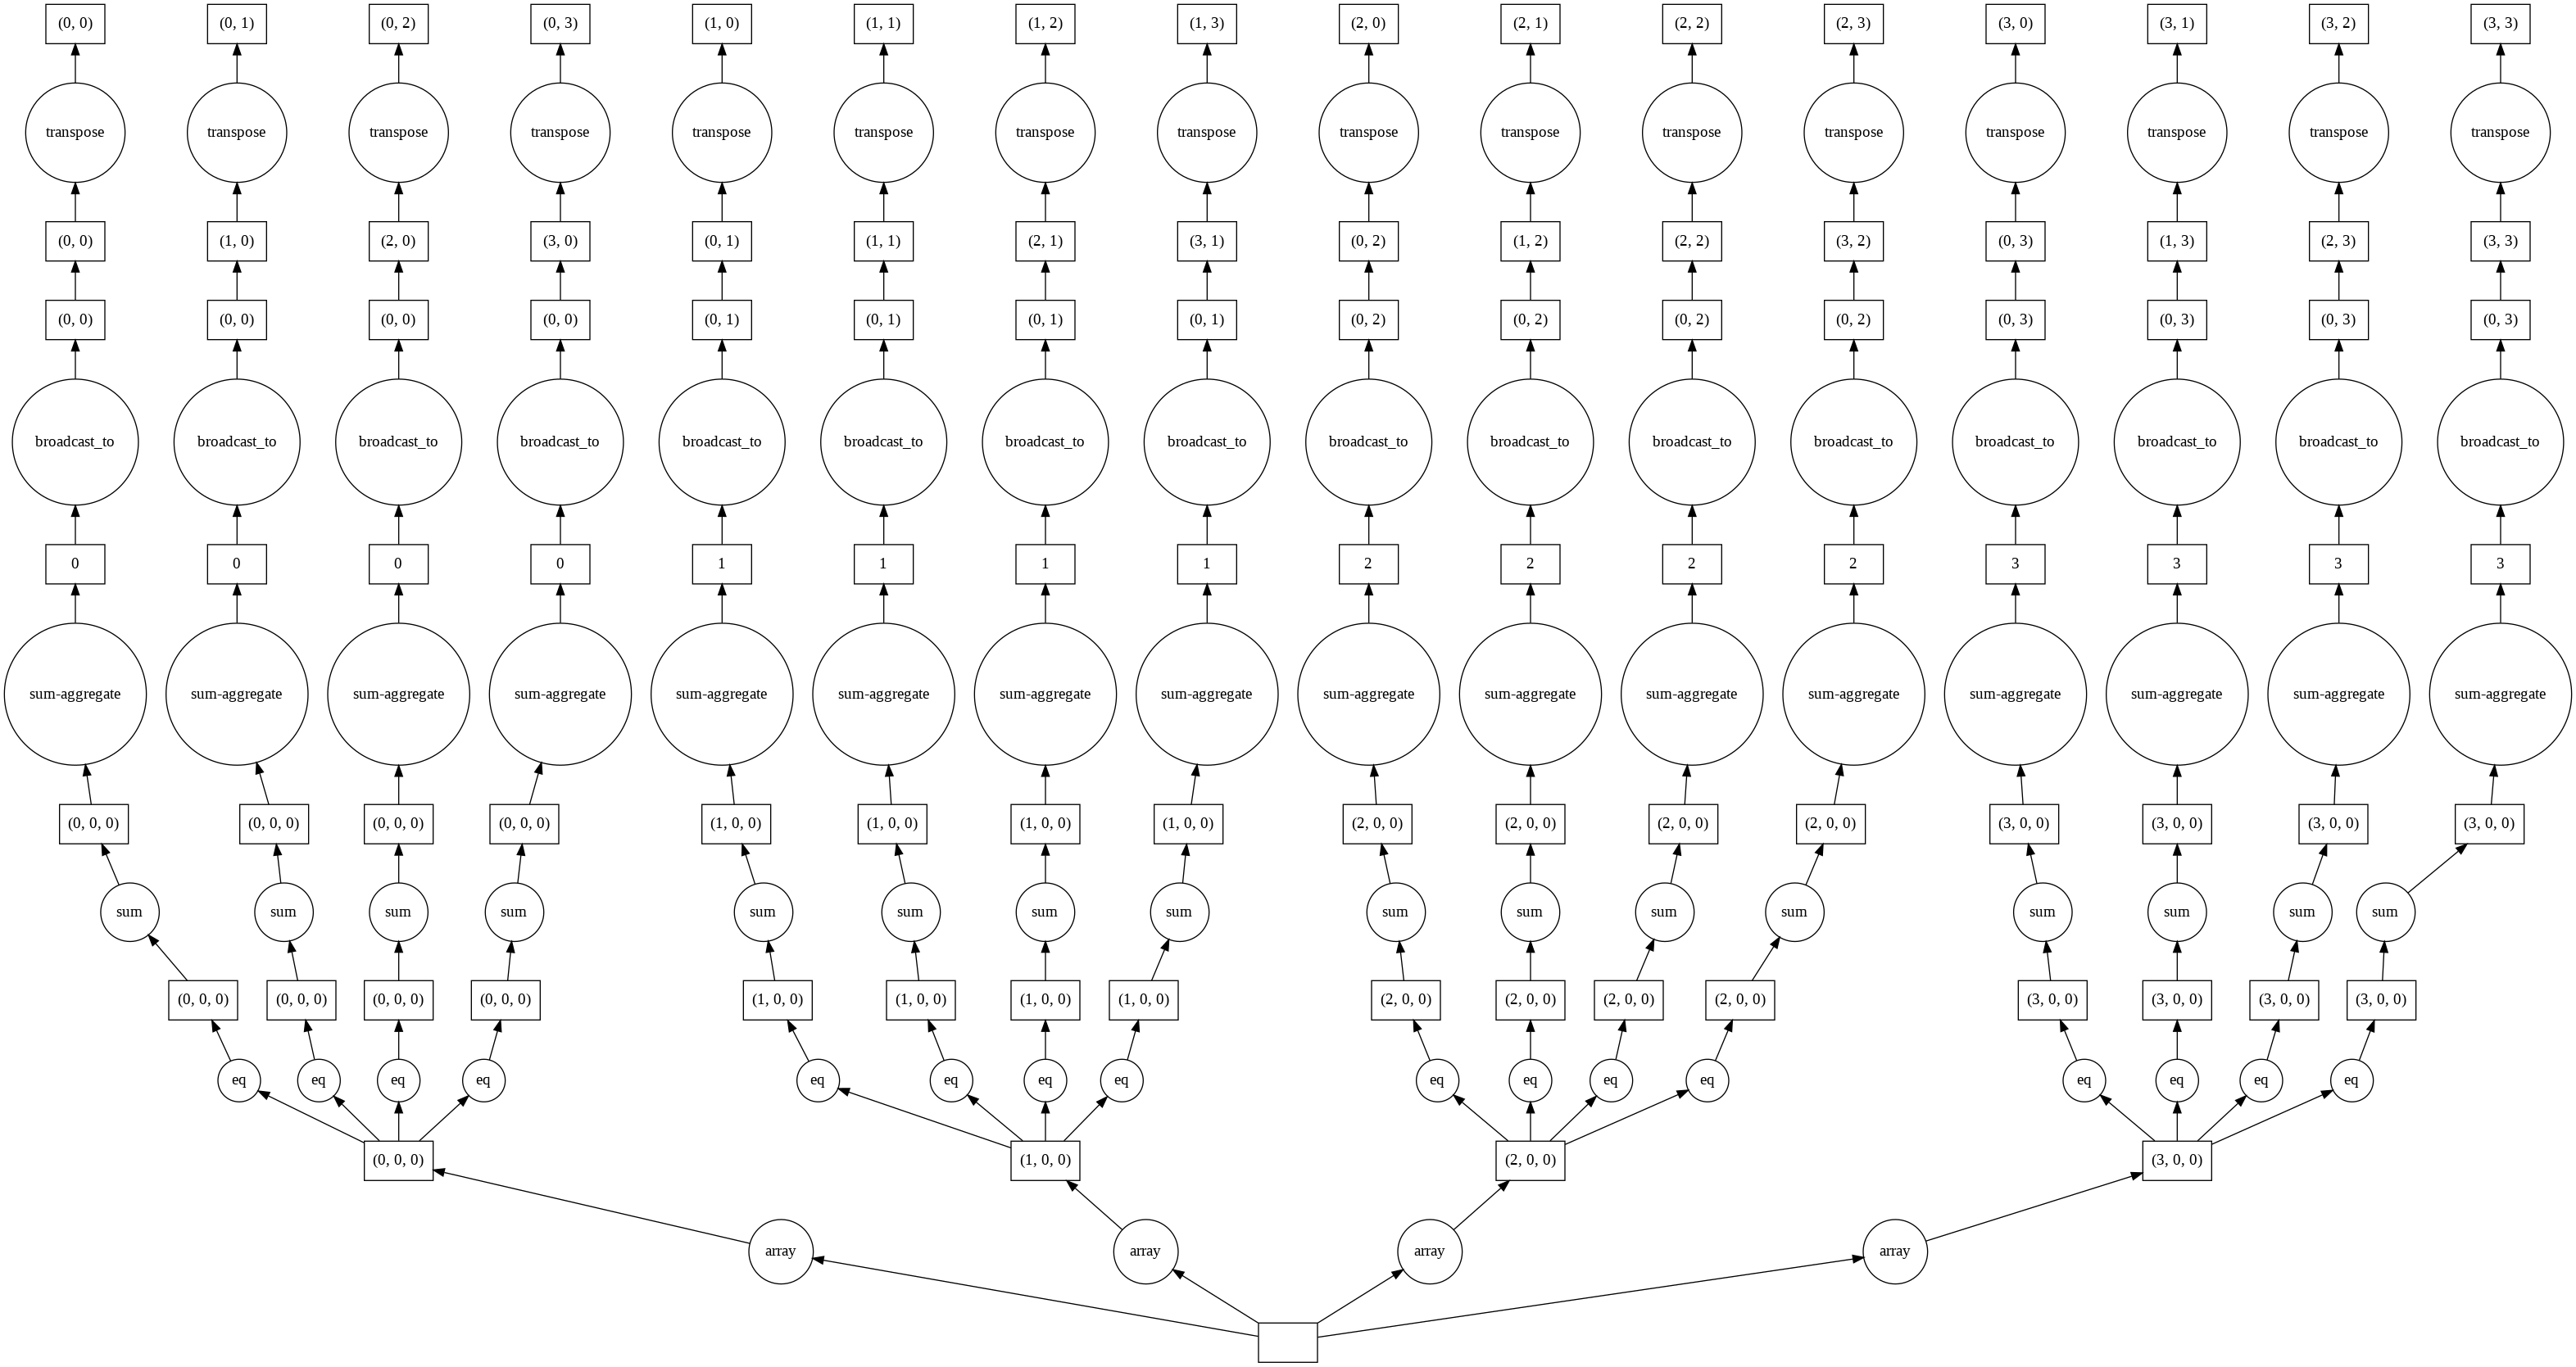

In [66]:
ac.data.visualize()